# Modell-Verbesserung: Schritt-für-Schritt

## Ziel: Aktuelles Modell systematisch verbessern

**Aktueller Stand:**
- Modell: CatBoost
- Test-RMSE: ~$44,643

**Verbesserungsstrategien:**
1. Feature Importance Analyse
2. Besseres Feature Engineering
3. Hyperparameter Tuning mit größerem Suchraum
4. Ensemble Methods (Stacking)
5. Feature Selection

## Schritt 1: Feature Importance Analyse

=== TOP 20 WICHTIGSTE FEATURES ===

                   feature  importance
  population_per_household   15.403152
    ocean_proximity_INLAND   14.535676
         log_median_income    7.230260
            distance_to_sf    7.092143
       median_income_cubed    6.776077
                 longitude    6.403620
             median_income    6.198957
                  latitude    5.595996
          income_times_age    5.581386
                  lat_long    4.672006
     median_income_squared    4.190249
        housing_median_age    2.631747
       rooms_per_household    2.431744
               geo_cluster    2.075423
                  long_bin    1.944750
         bedrooms_per_room    1.484743
ocean_proximity_NEAR OCEAN    1.101158
            total_bedrooms    0.631810
                   lat_bin    0.563256
           income_per_room    0.552058


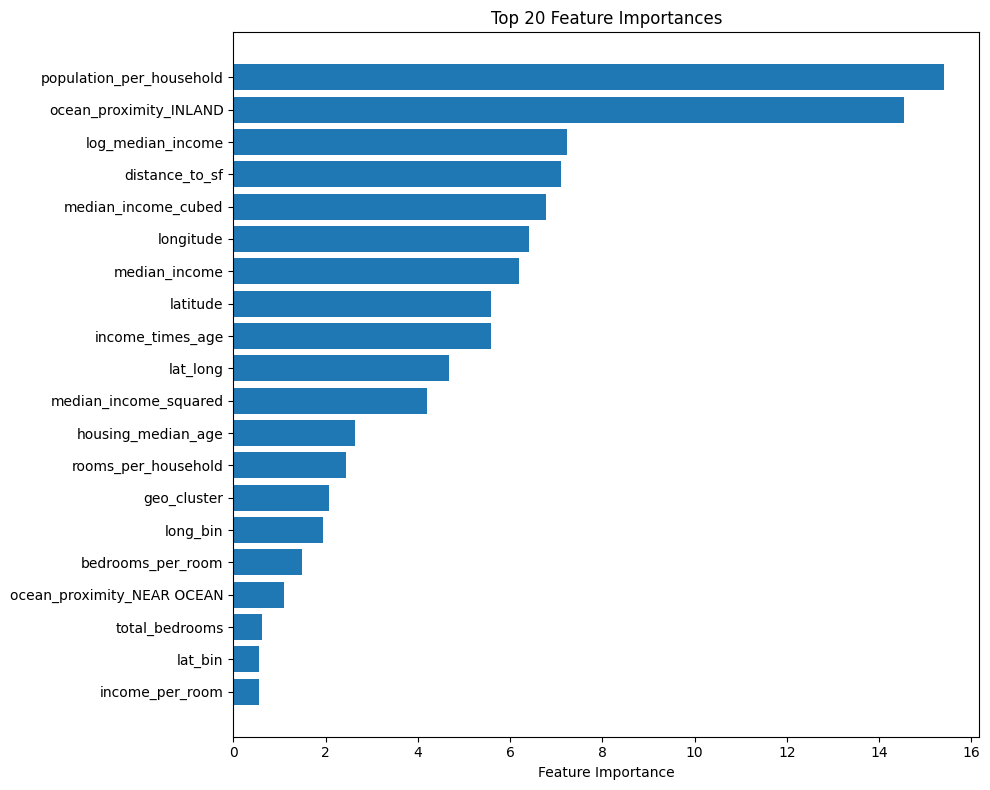


=== UNWICHTIGE FEATURES (< 0.5% Importance) ===
Anzahl: 1
['ocean_proximity_ISLAND']


In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Lade Modell
model = joblib.load('best_house_model.pkl')

# Lade und prepare Daten
housing = pd.read_csv("housing.csv")

# Feature Engineering (wie im Training)
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']
housing['median_income_squared'] = housing['median_income'] ** 2
housing['median_income_cubed'] = housing['median_income'] ** 3
housing['income_per_room'] = housing['median_income'] / (housing['total_rooms'] + 1)
housing['income_per_person'] = housing['median_income'] / (housing['population'] + 1)
housing['lat_long'] = housing['latitude'] * housing['longitude']
housing['income_times_age'] = housing['median_income'] * housing['housing_median_age']
housing['log_total_rooms'] = np.log1p(housing['total_rooms'])
housing['log_population'] = np.log1p(housing['population'])
housing['log_median_income'] = np.log1p(housing['median_income'])
housing['lat_bin'] = pd.cut(housing['latitude'], bins=10, labels=False)
housing['long_bin'] = pd.cut(housing['longitude'], bins=10, labels=False)
sf_lat, sf_long = 37.77, -122.41
housing['distance_to_sf'] = np.sqrt((housing['latitude'] - sf_lat)**2 + (housing['longitude'] - sf_long)**2)
housing['geo_cluster'] = 0
housing.replace([np.inf, -np.inf], np.nan, inplace=True)

X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hole Feature-Namen und Importances
try:
    num_features = model.named_steps['preproc'].named_transformers_['num'].feature_names_in_
    cat_encoder = model.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
    cat_features = cat_encoder.get_feature_names_out(['ocean_proximity'])
    feature_names = list(num_features) + list(cat_features)
    importances = model.named_steps['model'].feature_importances_
    
    feature_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("=== TOP 20 WICHTIGSTE FEATURES ===\n")
    print(feature_imp_df.head(20).to_string(index=False))
    
    # Visualisierung
    plt.figure(figsize=(10, 8))
    top_features = feature_imp_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Unwichtige Features
    threshold = 0.005
    unimportant = feature_imp_df[feature_imp_df['importance'] < threshold]
    print(f"\n=== UNWICHTIGE FEATURES (< {threshold*100}% Importance) ===")
    print(f"Anzahl: {len(unimportant)}")
    print(unimportant['feature'].tolist())
    
except Exception as e:
    print(f"Fehler: {e}")

## Schritt 2: Verbessertes Feature Engineering

Basierend auf Feature Importance: Erstelle neue, bessere Features

In [2]:
# NEUE FEATURES hinzufügen

def create_advanced_features(df):
    """Erstelle erweiterte Features"""
    df = df.copy()
    
    # Basis Features
    df['rooms_per_household'] = df['total_rooms'] / df['households']
    df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
    df['population_per_household'] = df['population'] / df['households']
    
    # Polynomiale Features
    df['median_income_squared'] = df['median_income'] ** 2
    df['median_income_cubed'] = df['median_income'] ** 3
    
    # Interaktionen
    df['income_per_room'] = df['median_income'] / (df['total_rooms'] + 1)
    df['income_per_person'] = df['median_income'] / (df['population'] + 1)
    df['lat_long'] = df['latitude'] * df['longitude']
    df['income_times_age'] = df['median_income'] * df['housing_median_age']
    
    # Log-Transformationen
    df['log_total_rooms'] = np.log1p(df['total_rooms'])
    df['log_population'] = np.log1p(df['population'])
    df['log_median_income'] = np.log1p(df['median_income'])
    
    # NEUE: Distanzen zu mehreren Städten
    cities = {
        'sf': (37.77, -122.41),
        'la': (34.05, -118.24),
        'san_diego': (32.72, -117.16),
        'sacramento': (38.58, -121.49)
    }
    
    for city_name, (lat, lon) in cities.items():
        df[f'distance_to_{city_name}'] = np.sqrt(
            (df['latitude'] - lat)**2 + (df['longitude'] - lon)**2
        )
    
    # NEUE: Minimale Distanz zu wichtigen Städten
    distance_cols = [f'distance_to_{city}' for city in cities.keys()]
    df['min_distance_to_city'] = df[distance_cols].min(axis=1)
    
    # NEUE: Küstennähe (boolean)
    df['is_coastal'] = df['ocean_proximity'].isin(['NEAR BAY', 'NEAR OCEAN', '<1H OCEAN']).astype(int)
    
    # NEUE: Dichte-Features
    df['rooms_per_person'] = df['total_rooms'] / (df['population'] + 1)
    df['bedrooms_per_household'] = df['total_bedrooms'] / df['households']
    
    # Binning
    df['lat_bin'] = pd.cut(df['latitude'], bins=10, labels=False)
    df['long_bin'] = pd.cut(df['longitude'], bins=10, labels=False)
    
    # Geografisches Clustering (RICHTIG implementiert)
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
    df['geo_cluster'] = kmeans.fit_predict(df[['latitude', 'longitude']])
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

# Test mit neuen Features
housing_v2 = pd.read_csv("housing.csv")
housing_v2 = create_advanced_features(housing_v2)

print(f"Neue Anzahl Features: {housing_v2.shape[1] - 1}")
print(f"\nNeue Features:")
new_cols = [c for c in housing_v2.columns if c not in housing.columns]
print(new_cols)

Neue Anzahl Features: 32

Neue Features:
['distance_to_la', 'distance_to_san_diego', 'distance_to_sacramento', 'min_distance_to_city', 'is_coastal', 'rooms_per_person', 'bedrooms_per_household']


## Schritt 3: Teste verbessertes Modell mit neuen Features

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# Prepare Data
X_v2 = housing_v2.drop("median_house_value", axis=1)
y_v2 = housing_v2["median_house_value"]

numeric_cols = X_v2.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_v2.columns if X_v2[c].dtype == "object"]

# Preprocessor
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", cat_transformer, categorical_cols)
])

# Train/Test Split
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

# Model mit gleichen Hyperparametern wie bestes Modell
pipeline_v2 = Pipeline([
    ("preproc", preprocessor),
    ("model", CatBoostRegressor(
        iterations=500,
        depth=8,
        learning_rate=0.05,
        l2_leaf_reg=3,
        subsample=0.8,
        silent=True,
        random_state=42
    ))
])

print("Training verbessertes Modell mit neuen Features...")
pipeline_v2.fit(X_train_v2, y_train_v2)
y_pred_v2 = pipeline_v2.predict(X_test_v2)
rmse_v2 = np.sqrt(mean_squared_error(y_test_v2, y_pred_v2))

print(f"\n=== VERGLEICH ===\n")
print(f"Original Modell RMSE:      $44,643")
print(f"Verbessertes Modell RMSE:  ${rmse_v2:,.2f}")
print(f"Verbesserung:              ${44643 - rmse_v2:,.2f}")
print(f"Verbesserung in %:         {((44643 - rmse_v2) / 44643 * 100):.2f}%")

Training verbessertes Modell mit neuen Features...

=== VERGLEICH ===

Original Modell RMSE:      $44,643
Verbessertes Modell RMSE:  $43,786.37
Verbesserung:              $856.63
Verbesserung in %:         1.92%


## Schritt 4: Hyperparameter Tuning mit RandomizedSearch

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Größerer Parameter-Suchraum
param_dist = {
    'model__iterations': [300, 500, 700, 1000],
    'model__depth': [6, 8, 10, 12],
    'model__learning_rate': uniform(0.01, 0.15),
    'model__l2_leaf_reg': randint(1, 10),
    'model__subsample': uniform(0.6, 0.4),
    'model__min_data_in_leaf': randint(1, 50)
}

pipeline_tuned = Pipeline([
    ("preproc", preprocessor),
    ("model", CatBoostRegressor(silent=True, random_state=42))
])

print("Starte RandomizedSearchCV (50 Iterationen)...")
random_search = RandomizedSearchCV(
    pipeline_tuned,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_v2, y_train_v2)

print(f"\nBeste Parameter:")
print(random_search.best_params_)

y_pred_tuned = random_search.predict(X_test_v2)
rmse_tuned = np.sqrt(mean_squared_error(y_test_v2, y_pred_tuned))

print(f"\n=== FINALE VERBESSERUNG ===\n")
print(f"Original Modell:           ${44643:,.2f}")
print(f"Mit neuen Features:        ${rmse_v2:,.2f}")
print(f"Nach Hyperparameter Tuning: ${rmse_tuned:,.2f}")
print(f"\nGesamte Verbesserung:      ${44643 - rmse_tuned:,.2f} ({((44643 - rmse_tuned) / 44643 * 100):.2f}%)")

Starte RandomizedSearchCV (50 Iterationen)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Beste Parameter:
{'model__depth': 8, 'model__iterations': 1000, 'model__l2_leaf_reg': 9, 'model__learning_rate': np.float64(0.08272449570384748), 'model__min_data_in_leaf': 33, 'model__subsample': np.float64(0.6479461469334731)}

=== FINALE VERBESSERUNG ===

Original Modell:           $44,643.00
Mit neuen Features:        $43,786.37
Nach Hyperparameter Tuning: $42,145.02

Gesamte Verbesserung:      $2,497.98 (5.60%)


## Schritt 5: Ensemble - Stacking mehrerer Modelle

In [5]:
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

# Base Models
estimators = [
    ('catboost', CatBoostRegressor(iterations=500, depth=8, learning_rate=0.05, silent=True, random_state=42)),
    ('xgboost', XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=42)),
    ('lightgbm', LGBMRegressor(n_estimators=500, max_depth=8, learning_rate=0.05, random_state=42, verbose=-1))
]

# Stacking mit Ridge als Meta-Learner
stacking_model = Pipeline([
    ("preproc", preprocessor),
    ("stacking", StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(),
        cv=5,
        n_jobs=-1
    ))
])

print("Training Stacking Ensemble...")
stacking_model.fit(X_train_v2, y_train_v2)
y_pred_stack = stacking_model.predict(X_test_v2)
rmse_stack = np.sqrt(mean_squared_error(y_test_v2, y_pred_stack))

print(f"\n=== FINALE ERGEBNISSE ===\n")
print(f"Original Modell:           ${44643:,.2f}")
print(f"Mit neuen Features:        ${rmse_v2:,.2f}")
print(f"Nach Hyperparameter Tuning: ${rmse_tuned:,.2f}")
print(f"Stacking Ensemble:         ${rmse_stack:,.2f}")
print(f"\nBeste Verbesserung:        ${44643 - min(rmse_v2, rmse_tuned, rmse_stack):,.2f}")

# Speichere bestes Modell
best_rmse = min(rmse_v2, rmse_tuned, rmse_stack)
if best_rmse == rmse_stack:
    joblib.dump(stacking_model, "best_house_model_v2.pkl")
    print("\n✓ Stacking Modell gespeichert als best_house_model_v2.pkl")
elif best_rmse == rmse_tuned:
    joblib.dump(random_search.best_estimator_, "best_house_model_v2.pkl")
    print("\n✓ Tuned Modell gespeichert als best_house_model_v2.pkl")
else:
    joblib.dump(pipeline_v2, "best_house_model_v2.pkl")
    print("\n✓ Modell mit neuen Features gespeichert als best_house_model_v2.pkl")

Training Stacking Ensemble...

=== FINALE ERGEBNISSE ===

Original Modell:           $44,643.00
Mit neuen Features:        $43,786.37
Nach Hyperparameter Tuning: $42,145.02
Stacking Ensemble:         $42,632.29

Beste Verbesserung:        $2,497.98

✓ Tuned Modell gespeichert als best_house_model_v2.pkl
